In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from data_utils import split_data_to_traj_and_control, mat2tracks
import wandb
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from pathlib import Path
from tqdm import tqdm

from models import DummyModel2
from train_utils import train_epoch, eval_epoch
from models import SplittedModel, SplittedModel2


In [5]:
data_root = "./data"
data_root = Path("./data")
folder_names = os.listdir(data_root)
folder_names.sort(key = lambda x: int(x.split("_")[0]))
folder_paths = [data_root / i for i in folder_names]
# folder_paths.pop(2)  # удаление неправильного файла с 50 треками
# folder_paths.pop(3)  # удаление неправильного файла с 50 треками
folder_paths

[WindowsPath('data/10_traj'),
 WindowsPath('data/25_traj'),
 WindowsPath('data/50_traj'),
 WindowsPath('data/100_traj'),
 WindowsPath('data/500_traj'),
 WindowsPath('data/750_traj'),
 WindowsPath('data/1000_traj')]

In [6]:
cur_dir_path =  folder_paths[0]

train_mat_path = cur_dir_path / "sdreDataset.mat"
val_mat_path = cur_dir_path / "sdreVal.mat"

train = scipy.io.loadmat(train_mat_path)["dataset"]
val = scipy.io.loadmat(val_mat_path)["sdreVal"]

In [7]:
print(train.shape, val.shape)

(1010, 3, 3) (10100, 3, 3)


In [8]:
def prepare_dataloaders_from_track(train, val, reshape=True):
    # train = scipy.io.loadmat(train_mat_path)["dataset"]
    # val = scipy.io.loadmat(val_mat_path)["sdreVal"]

    train_tracks = mat2tracks(train, reshape=reshape)
    val_tracks = mat2tracks(val, reshape=reshape)
    train_tracks = np.vstack(train_tracks) 
    val_tracks = np.vstack(val_tracks)

    train_dataset = split_data_to_traj_and_control(train_tracks)
    test_dataset = split_data_to_traj_and_control(val_tracks)
    print(f"len(train) = {len(train_dataset)} len(test) = {len(test_dataset)}")
  
    train_loader = DataLoader(train_dataset, 
                            batch_size=64, 
                            shuffle=True,
                            drop_last=True)

    test_loader = DataLoader(test_dataset, 
                            batch_size=64)
    
    return train_loader, test_loader

In [9]:
def get_model_crit_opt(hidden_dim_1=64, hidden_dim_2=64, dropout_rate=0.):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = DummyModel2(hidden_dim_1=hidden_dim_1, 
                    hidden_dim_2=hidden_dim_2, 
                    dropout_rate=dropout_rate)
    
    # model = SplittedModel2(hidden_dim_1=hidden_dim_1, 
    #                 hidden_dim_2=hidden_dim_2)
    
    model.to(device)
    criteria = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    return model, device, criteria, optimizer

def train_one_model(train, val, 
                    n_epoch=60,
                    hidden_dim_1=64, 
                    hidden_dim_2=64, 
                    dropout_rate=0.,
                    wandb_loggging=False):

    train_loader, test_loader = prepare_dataloaders_from_track(train, val)

    model, device, criteria, optimizer = get_model_crit_opt(hidden_dim_1=hidden_dim_1,
                                                             hidden_dim_2=hidden_dim_2,
                                                               dropout_rate=dropout_rate)

    best_loss = 1e6
    # save_path = f"MLP_3_{hidden_dim_1}_{hidden_dim_2}_6_best.pth"
    # save_path = f"splitted_model_best.pth"

    for epoch in tqdm(range(n_epoch)):
    # for epoch in range(100, 300):
        train_epoch(model, device, train_loader, criteria, optimizer)
        val_loss = eval_epoch(model, device, test_loader, criteria)
        
        if val_loss < best_loss:
            best_loss = val_loss
            # torch.save(model.state_dict(), save_path)
            # print(f"Improve eval losss on epoch {epoch} = ", best_loss)
            
        if wandb_loggging:
            wandb.log({
                "val_loss": val_loss,
                "epoch" : epoch
                })
            
    return best_loss.item()

In [10]:
# cur_dir_path = folder_paths[0]

# train_mat_path = cur_dir_path / "sdreDataset.mat"
# val_mat_path = cur_dir_path / "sdreVal.mat"
# train = scipy.io.loadmat(train_mat_path)["dataset"]
# val = scipy.io.loadmat(val_mat_path)["sdreVal"]

# best_loss = train_one_model(train, val)

In [11]:
# best_loss

In [12]:
n_traj = []
losses = []

for cur_dir_path in folder_paths:
    train_mat_path = cur_dir_path / "sdreDataset.mat"
    val_mat_path = cur_dir_path / "sdreVal.mat"
    train = scipy.io.loadmat(train_mat_path)["dataset"]
    val = scipy.io.loadmat(val_mat_path)["sdreVal"]
    best_loss = train_one_model(train, val)
    
    losses.append(best_loss)
    n_traj.append(int(str(cur_dir_path).split("\\")[1].split("_")[0]))
    print(f"best_loss = {best_loss}")

len(train) = 1010 len(test) = 10100


100%|██████████| 60/60 [00:09<00:00,  6.28it/s]


best_loss = 0.01789332553744316
len(train) = 2525 len(test) = 10100


100%|██████████| 60/60 [00:12<00:00,  4.97it/s]


best_loss = 0.013619870878756046
len(train) = 5050 len(test) = 10100


100%|██████████| 60/60 [00:15<00:00,  3.87it/s]


best_loss = 0.007410603109747171
len(train) = 10100 len(test) = 10100


100%|██████████| 60/60 [00:27<00:00,  2.16it/s]


best_loss = 0.006369066424667835
len(train) = 50500 len(test) = 10100


100%|██████████| 60/60 [01:51<00:00,  1.85s/it]


best_loss = 0.005171452648937702
len(train) = 75750 len(test) = 10100


100%|██████████| 60/60 [02:40<00:00,  2.68s/it]


best_loss = 0.005041036754846573
len(train) = 101000 len(test) = 10100


100%|██████████| 60/60 [03:28<00:00,  3.47s/it]

best_loss = 0.004775648005306721


Text(0, 0.5, 'MSE NN на валидации')

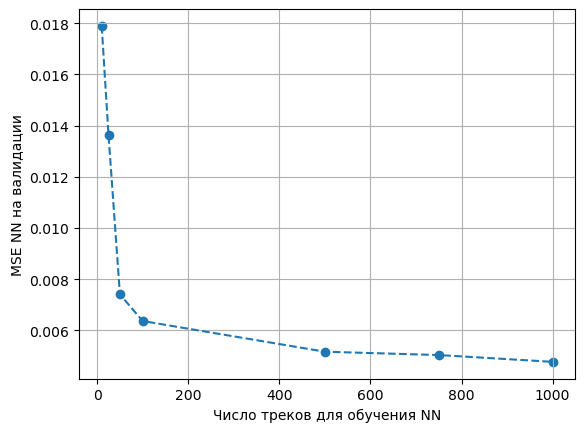

In [15]:
# n_traj[2] = 100

plt.scatter(n_traj, losses)
plt.plot(n_traj, losses, "--")
plt.grid()
plt.xlabel("Число треков для обучения NN")
plt.ylabel("MSE NN на валидации")

In [16]:
import pickle

save_data = {"n_traj" : n_traj, 
             "losses" : losses}


savename = "monolit_model"
# savename = "3_model_anfislike"

with open(f"{savename}.pickle", 'wb') as handle:
    pickle.dump(save_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [73]:
# for cur_dir_path in folder_paths:
#     train_mat_path = cur_dir_path / "sdreDataset.mat"
#     val_mat_path = cur_dir_path / "sdreVal.mat"

#     train = scipy.io.loadmat(train_mat_path)["dataset"]
#     val = scipy.io.loadmat(val_mat_path)["sdreVal"]
#     print(train.shape, val.shape)